In [1]:
%pylab inline


import numpy as np
import torch
import os
import sys
import pickle
#Importing the package
path = '/pbs/home/c/campagne/my_sps/MacroCanoniqueStat/'
sys.path.append(os.path.abspath(path+'WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/Wavelet_Packets'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG/Models'))
#Wavelets
from Wavelet_Packets import *
#Ansatz
from WCRG import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
#data
dirIn='./maps05_v1/'
data = np.load(dirIn+'maps.npy')

data = data**(-0.5) # to get normal distribution

Data = torch.tensor(data).to(device).to(torch.float32)
print(Data.mean(),Data.std())
#Normalising Data
Data= (Data - Data.mean())/Data.std()
print(Data.shape)
#Computing the number of scales
J=int(np.log2(Data.shape[-1])) #Images of size 2**J
print('J = '+str(J))

tensor(3.1253, device='cuda:0') tensor(0.3610, device='cuda:0')
torch.Size([5000, 128, 128])
J = 7


In [4]:
#Wavelet
m=4
W=Db_wavelets(m,device=device,mode='Periodic') #Debauchies 4

In [5]:
# I/O of model/synthesis
KEY="map_128"
dir_synth = './Synths/'
dir_mod = './Models/'

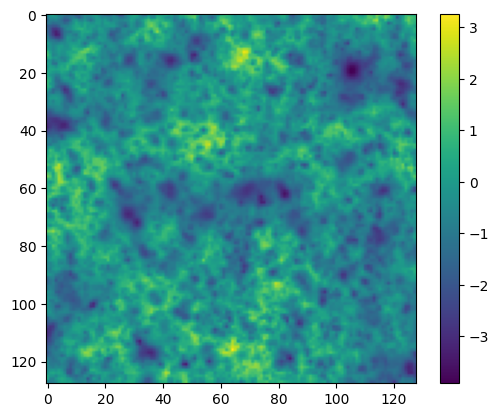

tensor(-0.4174, device='cuda:0')


In [6]:
imshow(Data[0].cpu());colorbar();
show()
print(Data[0].mean())

In [7]:
def my_Mala(ansatz_union,x_0,x_condi,n_steps,step_size,window_min,window_max, 
           n_print_freq=10) :
    """Conditionnal Windowed MALA Dynamic
    
    Parameters:
    ansatz_union (Condi_ansatz object) : The ansatz giving the gradient for MALA Dynamic
    x_0 (tensor) : (n_batch,n_chanels,N,N) Seed from which we start MALA dynamic
    x_condi (tensor) : (n_batch,n_condi,N',N') each batch element i is conditionned from x_condi[i]
    n_steps (int) : number of steps 
    step_size (float) : step size  
    window_min (float) : keep the update only if the reconstruction has no pixel < window_min
    window_max (float) : keep the update only if the reconstruction has no pixel > window_max

    
    
    Returns:
        x (tensor) :Result of MALA Dynamic (n_batch,n_chanels,N,N)
    
    """
    
    theta = ansatz_union.theta().detach() # (n_potentials,)
    
    x=torch.clone(x_0)
    n_batch = len(x)
    for _ in range(n_steps):
      # x (*,n_1,n_2,n_3)
      """Won't work if  has another shape"""
      # x_condi tuple of (*,n_1,..)
      #COMPUTE GRADIENT IN X_t
      gradient = ansatz_union.gradient(x,x_condi,theta) # (*,1,n_1,n_2,n_3)
      gradient = gradient[:,0] # (*,n_1,n_2,n_3)
      #COMPUTE NOISE
      noise = np.sqrt(2*step_size)*torch.randn_like(x) # (*,n_1,n_2,n_3)

      x_new = x - step_size * gradient + noise # (*,n_1,n_2,n_3)


      #METROPOLIS Rule
      gradient_new = ansatz_union.gradient(x_new,x_condi,theta) # (*,1,n_1,n_2,n_3)
      gradient_new = gradient_new[:,0]# (*,n_1,n_2,n_3)
    
      log_qx,log_qx_new  = log_Q(x_new.reshape((x.shape[0],-1)), x.reshape((x.shape[0],-1)),gradient.reshape((x.shape[0],-1)),gradient_new.reshape((x.shape[0],-1)), step_size) #(n_batch)
      
      
      log_pix = - ansatz_union.potential_batch(x,x_condi,theta).sum(1) #(*,)
      log_pix_new = - ansatz_union.potential_batch(x_new,x_condi,theta).sum(1) #(*,)
    
      log_ratio = log_pix_new-log_pix+log_qx - log_qx_new
      
      
    
      
      #Windowed Langevin, do not update outside of the window
      x_rec = ansatz_union.reconstruct(x_condi[0],x_new)
      #Both conditions
      ind_max =  torch.where(torch.max(x_rec.reshape((x_rec.shape[0],-1)),1)[0]>window_max)[0]
      ind_min =  torch.where(torch.max(-x_rec.reshape((x_rec.shape[0],-1)),1)[0]>-window_min)[0]
      RANDOM = torch.rand(log_ratio.shape,device = log_ratio.device )
      ind_mala = torch.where((RANDOM-torch.exp(log_ratio))>0)[0]
      if _%n_print_freq ==0:
        print('Acceptance_rate ='+str(1-len(ind_mala)/n_batch))
      x_new[ind_min] = x[ind_min]
      x_new[ind_max] = x[ind_max]
      x_new[ind_mala] = x[ind_mala]
      x = x_new
      
       
    
    return(x)



def my_LANGEVINMALA(ansatz_union,
             x_0,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat, Show_langevin = None,x_compare=None, 
                   n_print_freq=10):
                 
    """Conditionnal Windowed MALA Dynamic
    
    Parameters:
    ansatz_union (Condi_ansatz object) : The ansatz giving the gradient for MALA Dynamic
    x_0 (tensor) : (n_batch,L,L), dynamic is conditionned by x_0 low frequencies
    window_min (float) : keep the update only if the reconstruction has no pixel < window_min
    window_max (float) : keep the update only if the reconstruction has no pixel > window_max
    n_steps (int) : number of steps 
    step_size (float) : step size  
    n_batch (int) : MALA is applied to batches of size of size n_batch ( from x_0[n_batch*k:n_batch*(k+1)] low frequencies )
    n_repeat (int) : number of batches (k in range(n_repeat) )
    Show_langevin (func) : if specified, a plot function Show_langevin(x_0,x_reco) is runed
    x_compare (tensor) : if specified, a plot function Show_langevin(x_compare,x_reco) is runed
    

    
    
    Returns:
        x_reco (tensor) :Result of MALA Dynamic reconstructed using low frequencies from which it has been sampled (n_batch*n_repeat,L,L)
    
    """

    x_reco=[]
    for k in range(n_repeat):  
      print(f"repeat: {k+1}/{n_repeat}")
      x = x_0[n_batch*k:n_batch*(k+1)].cuda()
      x_condi,x_hf = ansatz_union.decompose(x)
      x_zeros = torch.zeros(x_hf.shape,device=x_hf.device)
      #x_zeros = torch.randn_like(x_hf)*(window_max-window_min)/2
      x_langevin = my_Mala(ansatz_union,x_zeros,x_condi,n_steps,step_size,window_min,window_max,
                           n_print_freq=n_print_freq)
      x_reco.append(ansatz_union.reconstruct(torch.repeat_interleave(x_condi[0], 1, dim=0),x_langevin).cpu())

    #Concatenate the sampled images
    x_reco = torch.concat(x_reco)
    if x_compare is None :
      x_compare = x_0
    #Compare to x_0 where we cut higher frequencies, if some where still there! 
    x_condi,x_hf = ansatz_union.decompose(x_compare)
    x = ansatz_union.reconstruct(x_condi[0],x_hf)

    #show
    if Show_langevin is not None:
        Show_langevin(x,x_reco)
    return(x_reco)

In [50]:
def my_Show_langevin(x,x_reco,log=False):
  """Compares original DATA and synthesis data X_fake

  Parameters:
  DATA (tensor): (n_batch,L,L)
  X_fake (tensor): (n_batch,L,L)
  log (Bool): if True log scale

  """
  Compare_Spectrum(x,x_reco,log=log)

  plt.hist(x_reco.detach().cpu().reshape((-1,)),label='Langevin',density=True, cumulative=True,bins=50)
  plt.hist(x.detach().cpu().reshape((-1,)),alpha=0.5,label='True',density=True, cumulative=True,bins=50)
  plt.legend()
  plt.show()

  plt.hist(x_reco.detach().cpu().reshape((-1,)),label='Langevin',density=True, cumulative=False,bins=50)
  plt.hist(x.detach().cpu().reshape((-1,)),alpha=0.5,label='True',density=True, cumulative=False,bins=50)
  if log == True:
      plt.yscale('log')
  plt.legend()
  plt.show()

  print('mean_true = '+str(x.detach().cpu().reshape((-1,)).mean()))
  print('std_true = '+str(x.detach().cpu().reshape((-1,)).reshape((-1,)).std()))
  print('mean_langevin = '+str((x_reco).detach().cpu().reshape((-1,)).mean()))
  print('std_langevin = '+str((x_reco).detach().cpu().reshape((-1,)).std()))

  #Sample example
  plt.imshow(x[0].detach().cpu())
  plt.title('True')
  plt.show()
  plt.imshow(x_reco[0].detach().cpu())
  plt.title('Langevin')
  plt.show()
  

  #Covariances (Stationnary)
  cov_x = sfft.fftshift(torch.fft.ifft2(torch.fft.fft2(x).abs()**2).mean(0).detach().cpu().real)
  cov_langevin = sfft.fftshift(torch.fft.ifft2(torch.fft.fft2(x_reco).abs()**2).mean(0).detach().cpu().real)
  plt.imshow(cov_x)
  plt.title('True')
  plt.colorbar()
  plt.show()
  plt.imshow(cov_langevin)
  plt.title('Langevin')
  plt.colorbar()
  plt.show()


# L= 1

In [247]:
#Define Scale, maps of size 1*1 = L*L
L=1
depth = J-int(np.log2(L))
#print(depth)
#Load Real data x_J, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

In [248]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [249]:
#Sampling
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(phi_s)
n_steps = 500
step_size = 300
x_reco = my_LANGEVINMALA(ansatz,
             torch.zeros_like(phi_s),
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/1
Acceptance_rate =0.9398
Acceptance_rate =0.9516
Acceptance_rate =0.9462
Acceptance_rate =0.9476
Acceptance_rate =0.9462
Acceptance_rate =0.9482
Acceptance_rate =0.9354
Acceptance_rate =0.949
Acceptance_rate =0.95
Acceptance_rate =0.9484


In [250]:
x_reco.shape, phi_s.shape

(torch.Size([5000, 1, 1]), torch.Size([5000, 1, 1]))

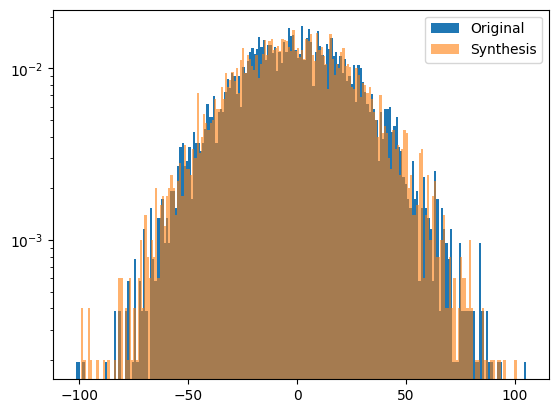

In [251]:
compare_hist(x_reco,phi_s)

In [252]:
#save the generated x_J
save(x_reco,L,KEY,dir_synth)

# L = 2

In [253]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=2
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 6


In [254]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)


In [255]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 100
step_size = 25
n_repeat = 1
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 1, 1])
torch.Size([5000, 2, 2])
repeat: 1/1
Acceptance_rate =0.9832
Acceptance_rate =0.9838
Acceptance_rate =0.985
Acceptance_rate =0.9852
Acceptance_rate =0.984
Acceptance_rate =0.984
Acceptance_rate =0.9824
Acceptance_rate =0.9798
Acceptance_rate =0.9832
Acceptance_rate =0.9846


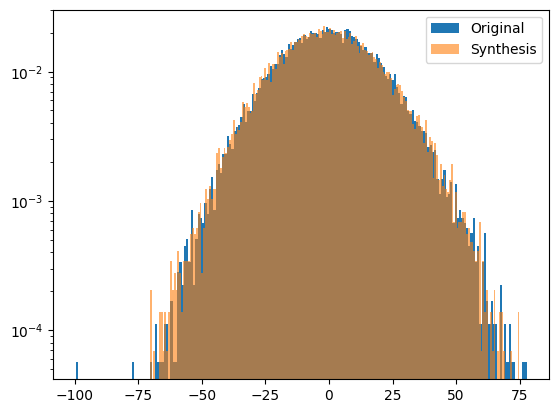

In [256]:
compare_hist(x_reco,phi_s)

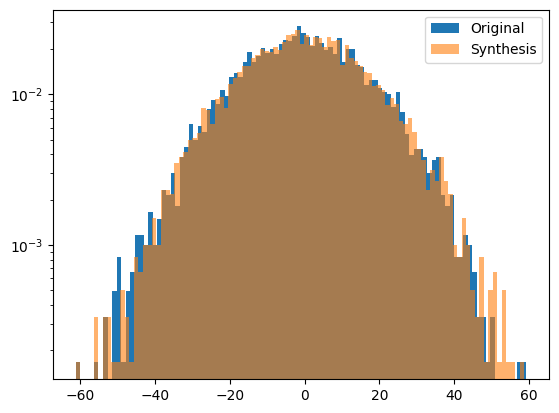

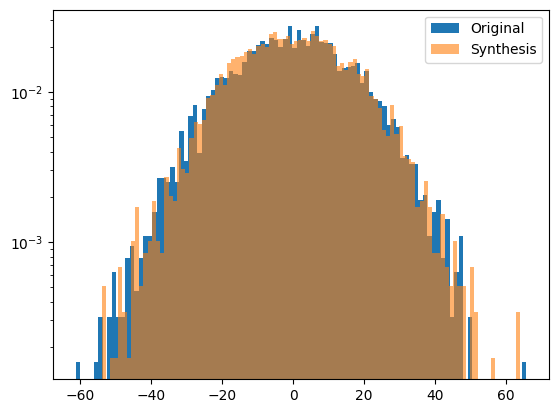

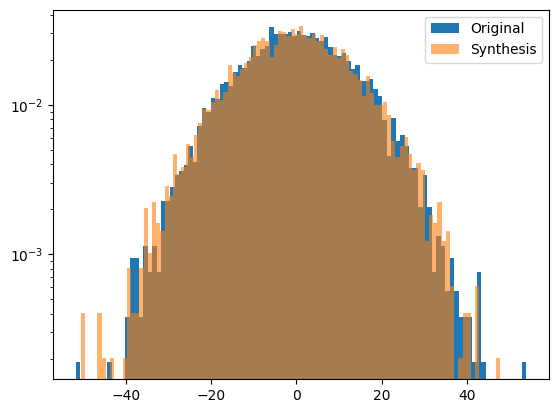

In [258]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [259]:
save(x_reco,L,KEY,dir_synth)

# L = 4

In [260]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=4
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J, show_hist=False)

depth = 5


In [261]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [262]:
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 40
step_size = 10
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 2, 2])
torch.Size([5000, 4, 4])
repeat: 1/1
Acceptance_rate =0.907
Acceptance_rate =0.9186
Acceptance_rate =0.922
Acceptance_rate =0.9216
Acceptance_rate =0.9222
Acceptance_rate =0.9286
Acceptance_rate =0.9318
Acceptance_rate =0.9278
Acceptance_rate =0.9214
Acceptance_rate =0.9296


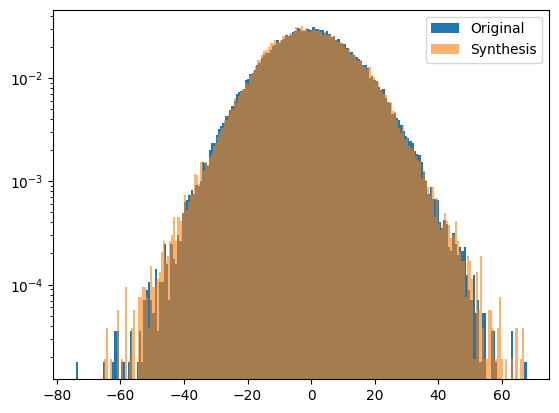

In [263]:
compare_hist(x_reco,phi_s,)

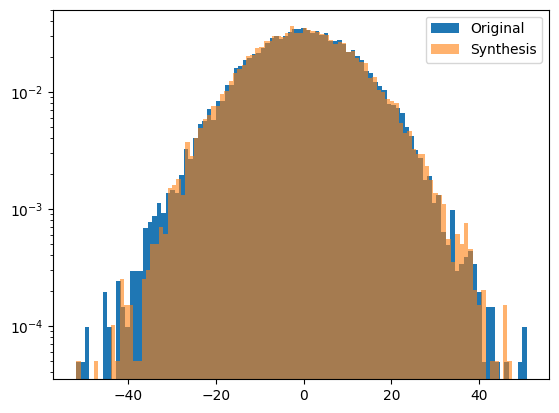

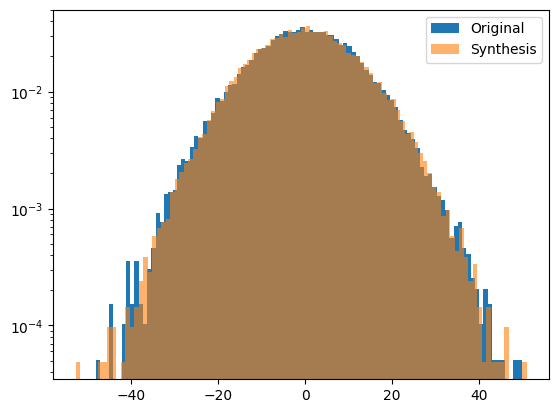

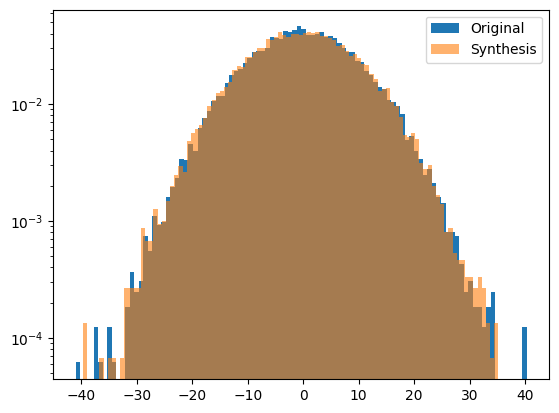

In [264]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)


In [265]:
save(x_reco,L,KEY,dir_synth)

# L = 8

In [282]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=8
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 4


In [283]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)


In [284]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 1
n_batch = len(x_reco)
n_steps = 100
step_size = 8
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

torch.Size([5000, 4, 4])
torch.Size([5000, 8, 8])
repeat: 1/1
Acceptance_rate =0.30720000000000003
Acceptance_rate =0.7142
Acceptance_rate =0.7568
Acceptance_rate =0.7668
Acceptance_rate =0.769
Acceptance_rate =0.7676000000000001
Acceptance_rate =0.7682
Acceptance_rate =0.7605999999999999
Acceptance_rate =0.7604
Acceptance_rate =0.7652


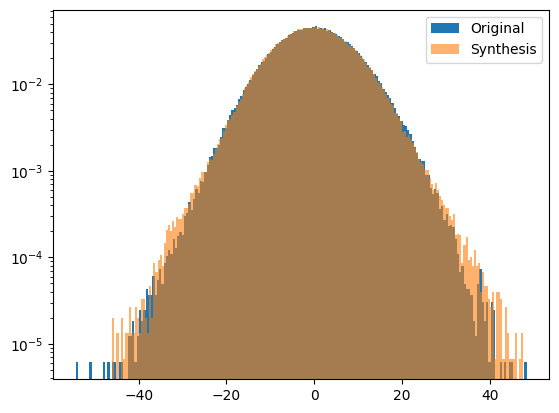

In [285]:
compare_hist(x_reco,phi_s)

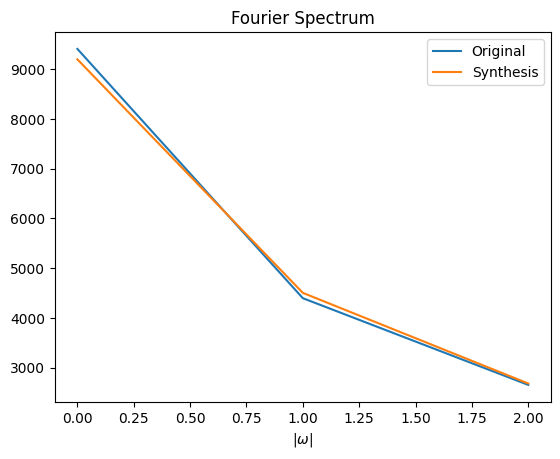

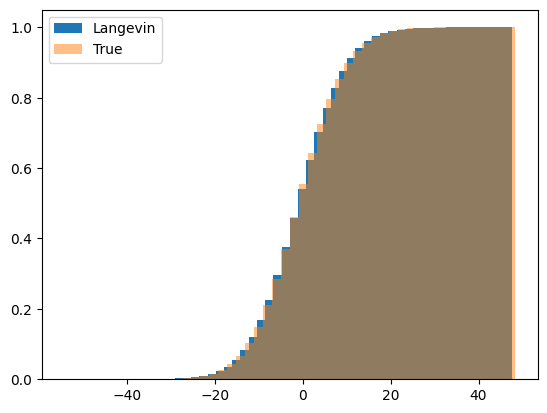

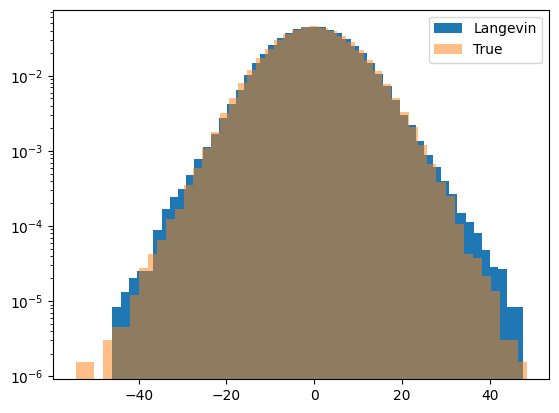

mean_true = tensor(-4.5212e-06)
std_true = tensor(8.9869)
mean_langevin = tensor(-0.0845)
std_langevin = tensor(9.0269)


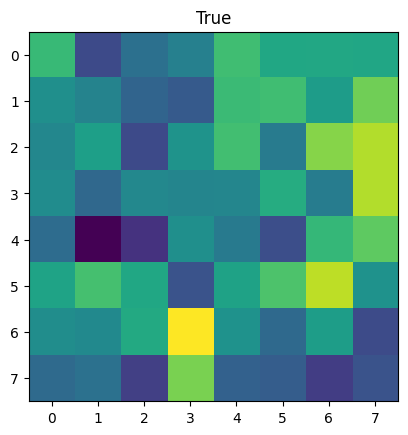

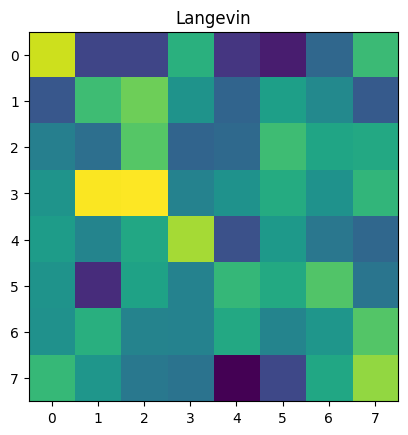

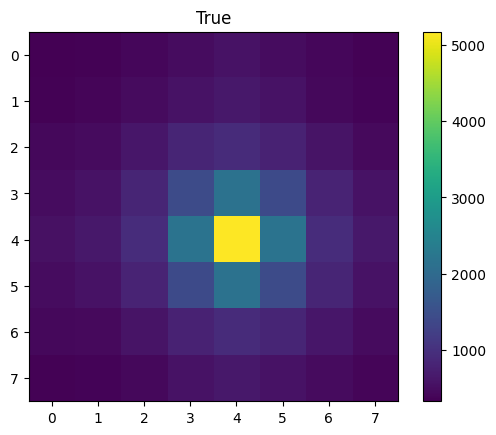

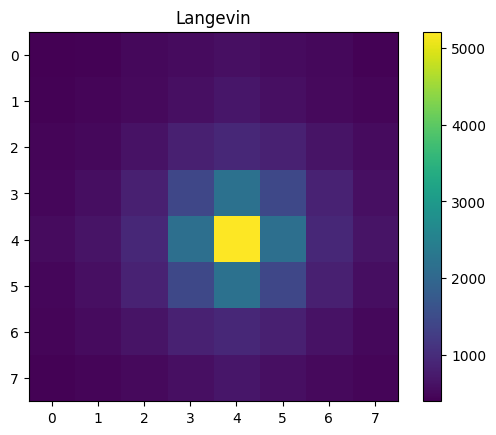

In [286]:
#Compare Synthesis and originals
Show_langevin(phi_s,x_reco,log=True)


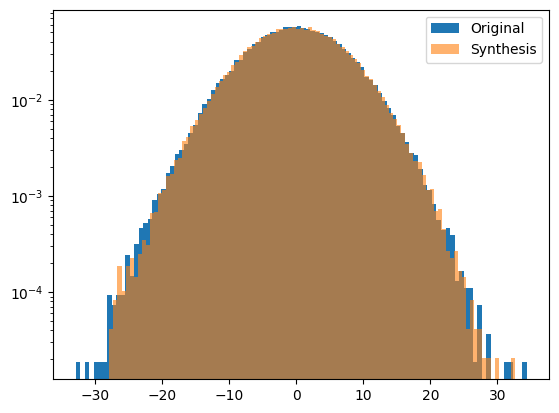

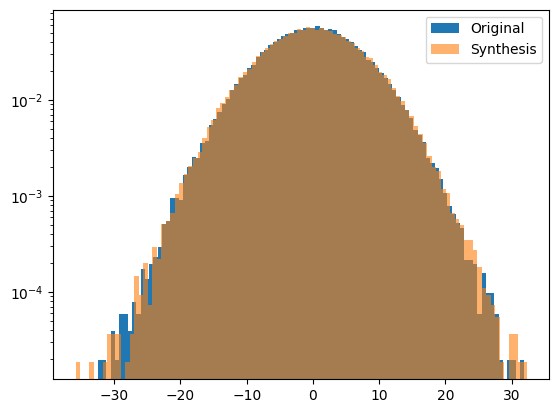

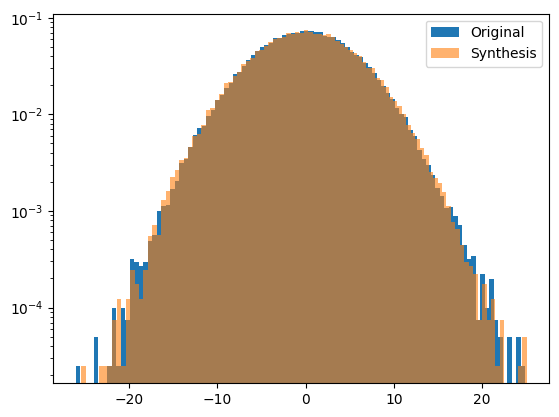

In [287]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [170]:
save(x_reco,L,KEY,dir_synth)

# L = 16

In [288]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [289]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=16
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 3


In [290]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [291]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

torch.Size([5000, 8, 8])
torch.Size([5000, 16, 16])


In [292]:

window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 10
n_batch = len(x_reco)//n_repeat  # was conditionned by phi_s?!
n_steps = 200
step_size = 5e-1
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/10
Acceptance_rate =0.842
Acceptance_rate =0.946
Acceptance_rate =0.964
Acceptance_rate =0.95
Acceptance_rate =0.96
Acceptance_rate =0.946
Acceptance_rate =0.974
Acceptance_rate =0.956
Acceptance_rate =0.958
Acceptance_rate =0.964
repeat: 2/10
Acceptance_rate =0.83
Acceptance_rate =0.9299999999999999
Acceptance_rate =0.964
Acceptance_rate =0.956
Acceptance_rate =0.966
Acceptance_rate =0.976
Acceptance_rate =0.958
Acceptance_rate =0.978
Acceptance_rate =0.968
Acceptance_rate =0.954
repeat: 3/10
Acceptance_rate =0.8220000000000001
Acceptance_rate =0.958
Acceptance_rate =0.962
Acceptance_rate =0.964
Acceptance_rate =0.968
Acceptance_rate =0.968
Acceptance_rate =0.958
Acceptance_rate =0.982
Acceptance_rate =0.96
Acceptance_rate =0.952
repeat: 4/10
Acceptance_rate =0.872
Acceptance_rate =0.95
Acceptance_rate =0.954
Acceptance_rate =0.952
Acceptance_rate =0.966
Acceptance_rate =0.97
Acceptance_rate =0.958
Acceptance_rate =0.968
Acceptance_rate =0.974
Acceptance_rate =0.962
repeat: 

In [293]:
phi_s.shape, x_reco.shape

(torch.Size([5000, 16, 16]), torch.Size([5000, 16, 16]))

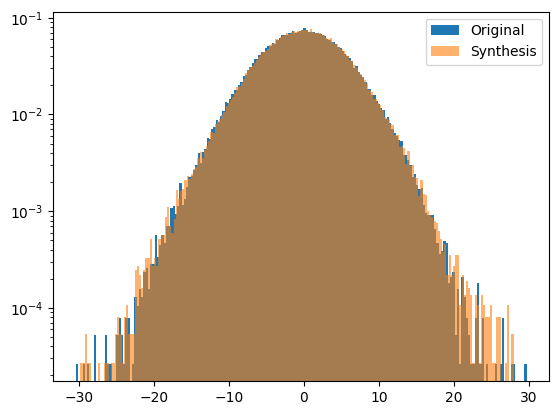

In [294]:
compare_hist(x_reco[::10],phi_s[::10],)

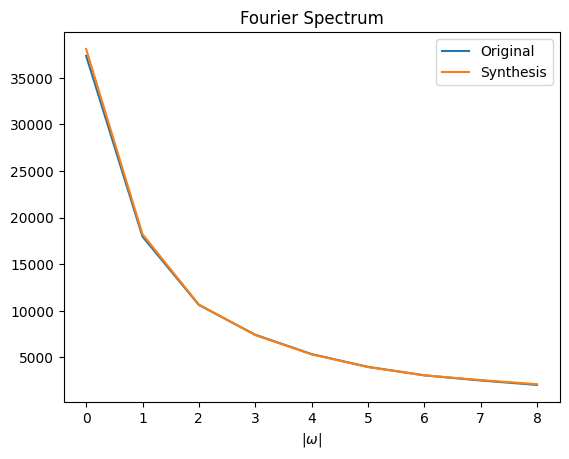

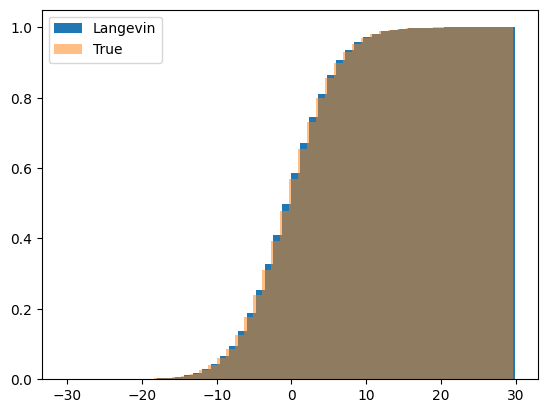

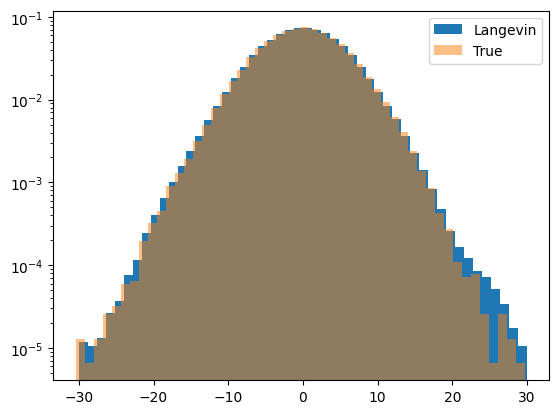

mean_true = tensor(-0.1011)
std_true = tensor(5.6048)
mean_langevin = tensor(-0.0183)
std_langevin = tensor(5.6275)


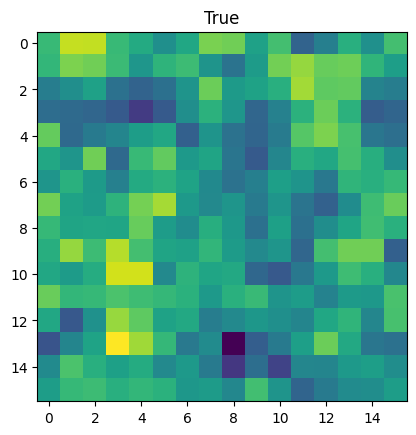

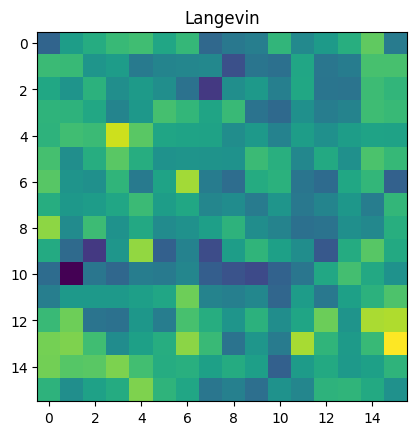

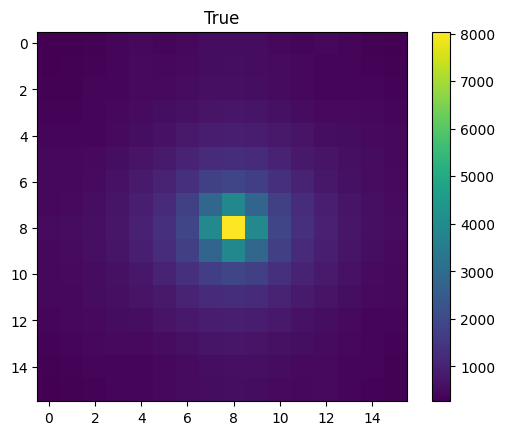

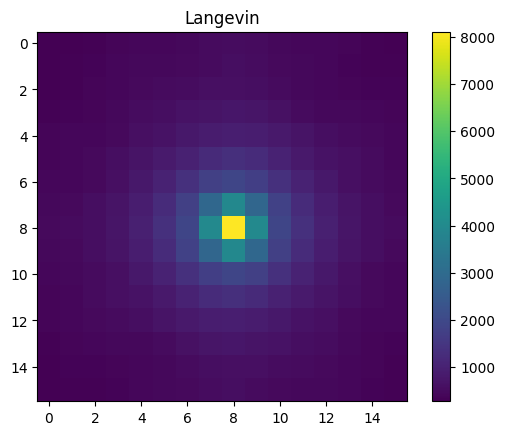

In [295]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

In [296]:
save(x_reco,L,KEY,dir_synth)

# L = 32

In [344]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [345]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=32
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 2


In [346]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [347]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

torch.Size([5000, 16, 16])
torch.Size([5000, 32, 32])


In [348]:
# JEC 20/6/23 n_batch x n_repeat = len(x_reco)  
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_repeat = 10
n_batch = (len(x_reco)//10)//n_repeat # was 500 JEC 20/6/23    2h with whole dataset
n_steps =  300   # was 500  JEC 19/6/23
step_size = 3e-1 #1e-1 4.5e-1 # was 1e-1 JEC 19/6/23
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/10
Acceptance_rate =0.06000000000000005
Acceptance_rate =0.31999999999999995
Acceptance_rate =0.56
Acceptance_rate =0.6599999999999999
Acceptance_rate =0.7
Acceptance_rate =0.78
Acceptance_rate =0.8200000000000001
Acceptance_rate =0.74
Acceptance_rate =0.86
Acceptance_rate =0.86
repeat: 2/10
Acceptance_rate =0.07999999999999996
Acceptance_rate =0.21999999999999997
Acceptance_rate =0.48
Acceptance_rate =0.8200000000000001
Acceptance_rate =0.84
Acceptance_rate =0.74
Acceptance_rate =0.86
Acceptance_rate =0.84
Acceptance_rate =0.76
Acceptance_rate =0.78
repeat: 3/10
Acceptance_rate =0.06000000000000005
Acceptance_rate =0.31999999999999995
Acceptance_rate =0.5800000000000001
Acceptance_rate =0.76
Acceptance_rate =0.74
Acceptance_rate =0.76
Acceptance_rate =0.76
Acceptance_rate =0.78
Acceptance_rate =0.78
Acceptance_rate =0.76
repeat: 4/10
Acceptance_rate =0.06000000000000005
Acceptance_rate =0.21999999999999997
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.82000000

In [349]:
phi_s.shape, x_reco.shape

(torch.Size([5000, 32, 32]), torch.Size([500, 32, 32]))

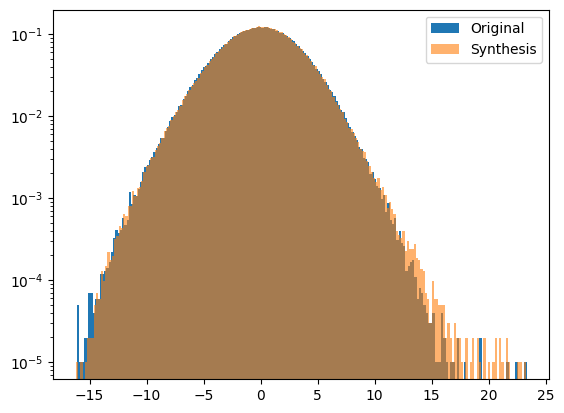

In [350]:
compare_hist(x_reco,phi_s[::10])

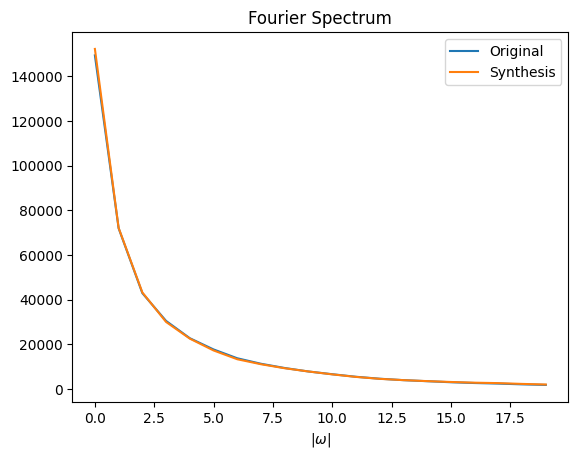

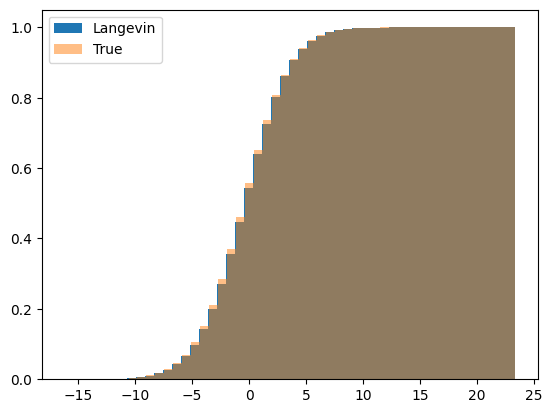

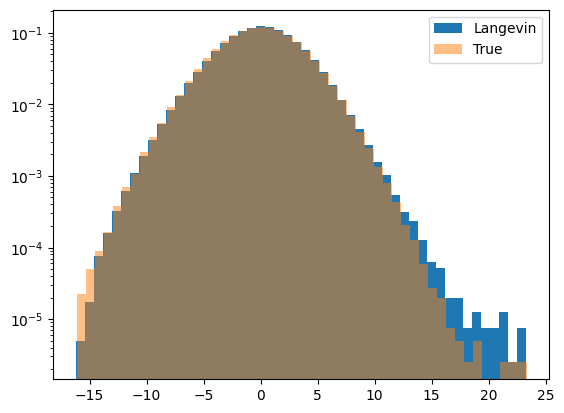

mean_true = tensor(-0.0506)
std_true = tensor(3.4013)
mean_langevin = tensor(-0.0242)
std_langevin = tensor(3.4001)


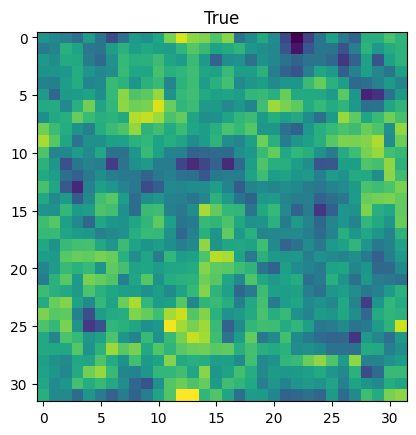

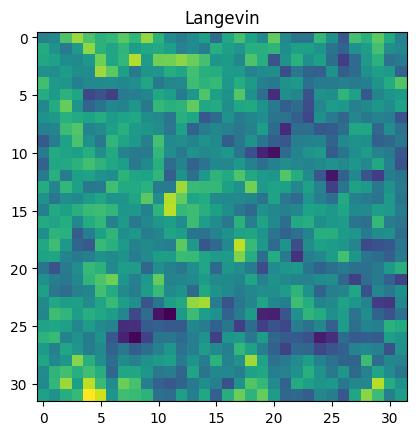

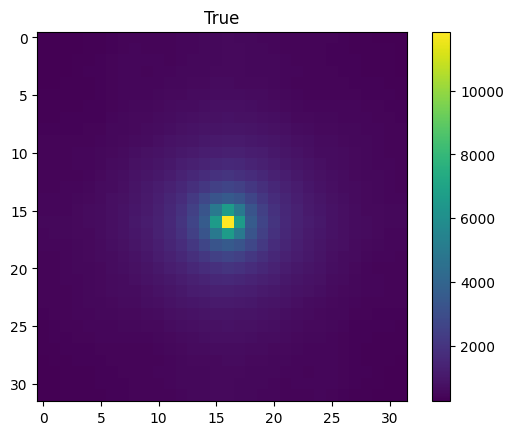

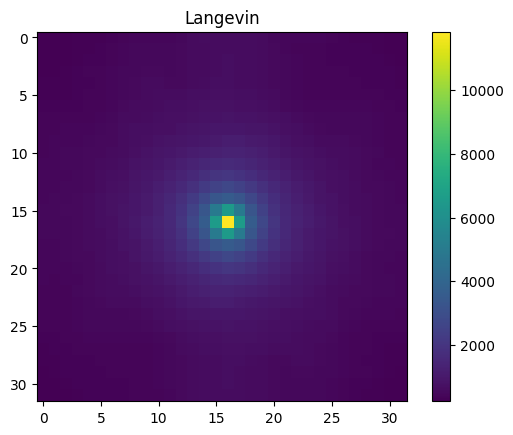

In [351]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

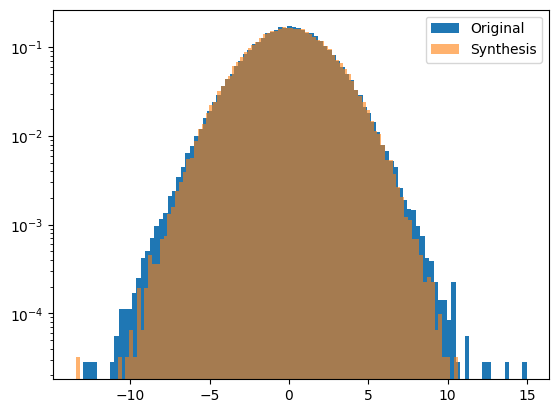

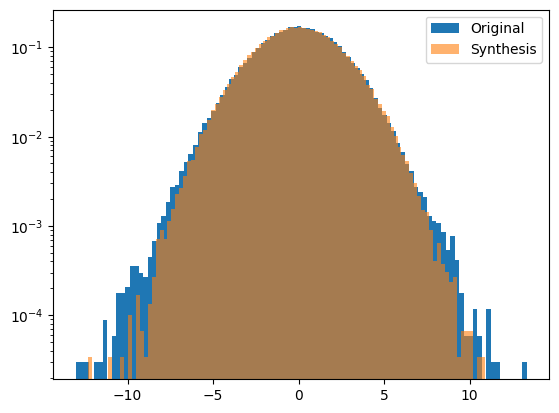

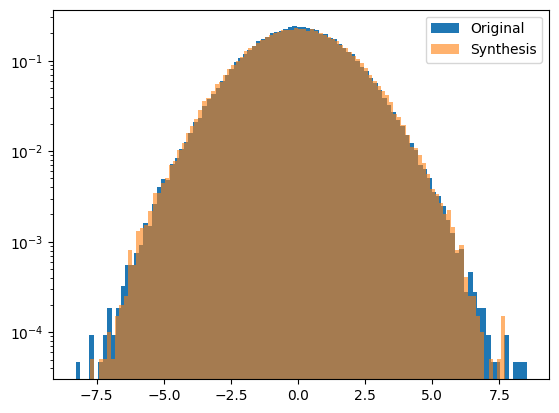

In [352]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)


In [353]:
save(x_reco,L,KEY,dir_synth)

# L = 64

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [9]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=64
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 1


In [10]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [11]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

torch.Size([500, 32, 32])
torch.Size([500, 64, 64])


In [13]:
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_batch = 20 # was 200 JEC 20/6/23
n_repeat = len(x_reco)//n_batch  # was 1 JEC 20/6/23

n_steps = 250 # was 250
step_size = 2.0e-2 # was 1.5e-2
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/25
Acceptance_rate =0.0
Acceptance_rate =0.050000000000000044
Acceptance_rate =0.25
Acceptance_rate =0.5
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.65
Acceptance_rate =0.85
repeat: 2/25
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.44999999999999996
Acceptance_rate =0.55
Acceptance_rate =0.55
Acceptance_rate =0.7
Acceptance_rate =0.85
Acceptance_rate =0.85
Acceptance_rate =0.8
repeat: 3/25
Acceptance_rate =0.050000000000000044
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.15000000000000002
Acceptance_rate =0.55
Acceptance_rate =0.75
Acceptance_rate =0.6
Acceptance_rate =0.7
Acceptance_rate =0.85
Acceptance_rate =0.8
Acceptance_rate =0.8
repeat: 4/25
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.0
Acceptance_rate =0.35
Acceptance_rate =0.6
Acceptance_rate =0.8
Acceptance_rate =0.65
Acceptance_rate =0.85
Acceptance_rate =0.7
Acceptance_rate =0.8
Ac

In [14]:
x_reco.shape, phi_s.shape

(torch.Size([500, 64, 64]), torch.Size([5000, 64, 64]))

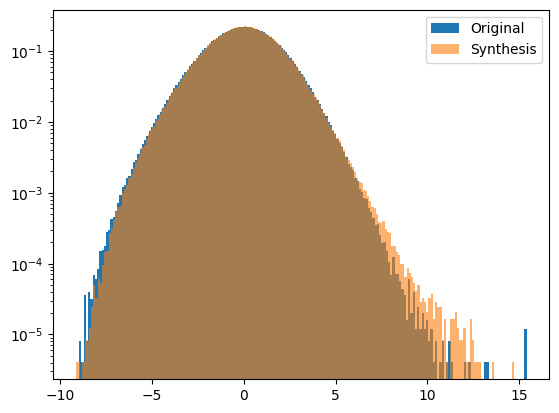

In [15]:
compare_hist(x_reco,phi_s[::10])

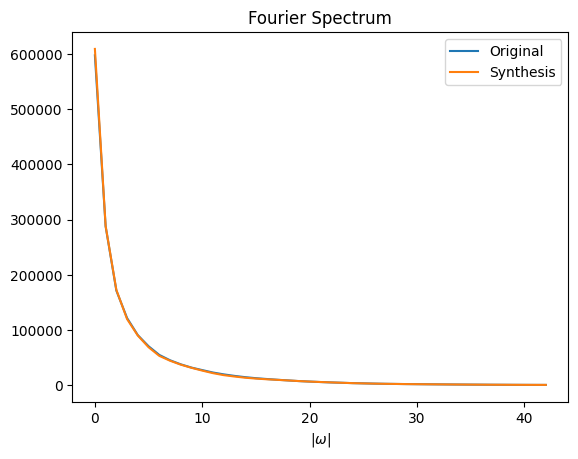

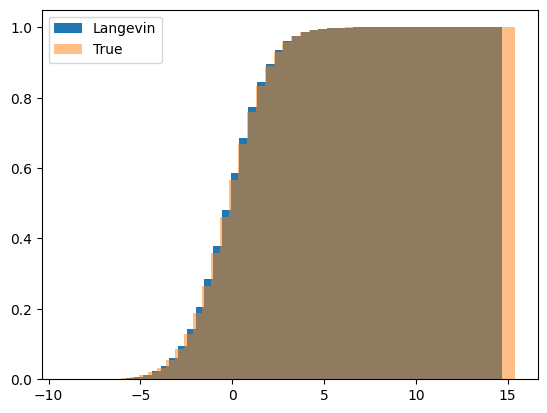

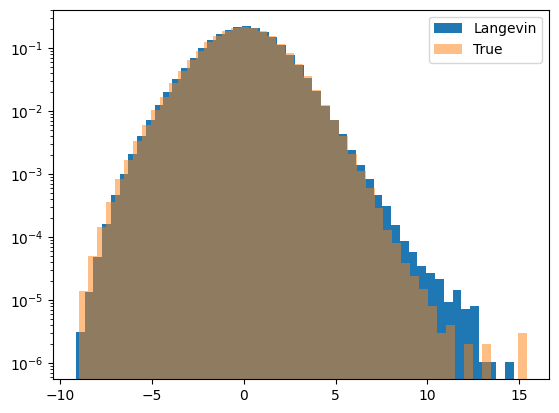

mean_true = tensor(-0.0253)
std_true = tensor(1.9026)
mean_langevin = tensor(-0.0121)
std_langevin = tensor(1.8901)


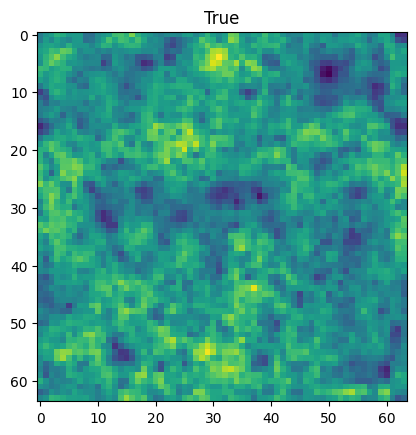

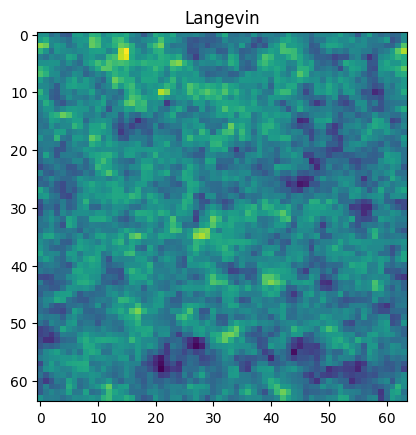

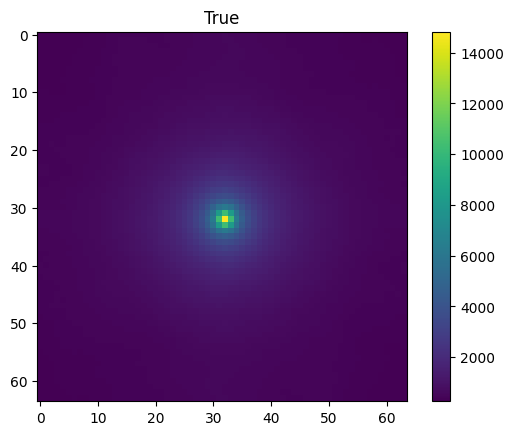

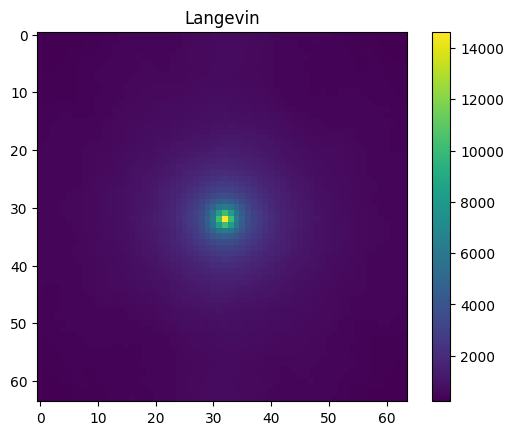

In [16]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

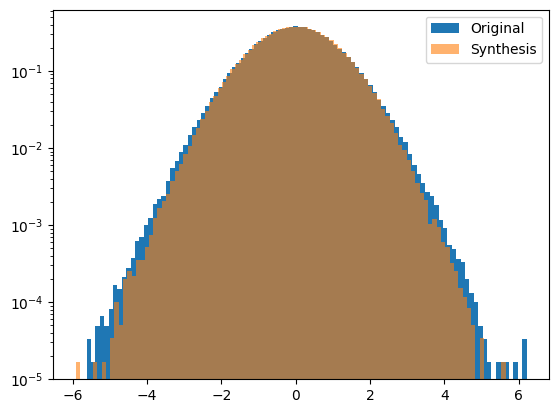

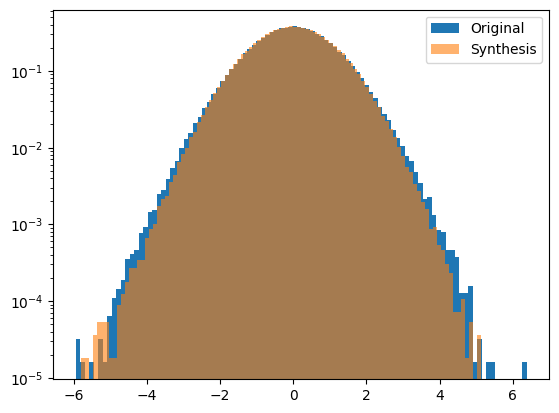

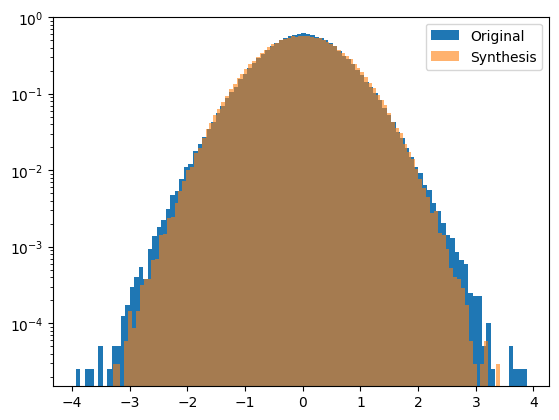

In [393]:
x_high_reco = ansatz.decompose(x_reco.cuda())[1]
x_high = ansatz.decompose(phi_s)[1][:len(x_reco)]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

In [17]:
save(x_reco,L,KEY,dir_synth)

# L = 128

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [41]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


In [42]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)

In [43]:
#We generate \bar x_{j+1} conditionaly to previously sampled x_{j+1}
x_reco = load(L//2,KEY,W,dir_synth)

torch.Size([500, 64, 64])
torch.Size([500, 128, 128])


In [44]:
window_min,window_max = ansatz.ansatze[0].centers[0],ansatz.ansatze[0].centers[-1]
n_batch =  10 #JEC 20/6/23

#n_batch = 100 # was 200 JEC 20/6/23
n_repeat = len(x_reco)//n_batch  # was 1 JEC 20/6/23

n_steps = 500
step_size = 7e-4 # xwas 2e-3
x_reco = my_LANGEVINMALA(ansatz,
             x_reco,
             window_min,
             window_max,
             n_steps,
             step_size,
             n_batch,
             n_repeat,
            n_print_freq=n_steps//10)

repeat: 1/50
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.5
Acceptance_rate =0.30000000000000004
Acceptance_rate =0.8
Acceptance_rate =0.9
Acceptance_rate =0.7
Acceptance_rate =0.9
Acceptance_rate =0.7
repeat: 2/50
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.30000000000000004
Acceptance_rate =0.5
Acceptance_rate =0.7
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.8
Acceptance_rate =0.9
repeat: 3/50
Acceptance_rate =0.0
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.7
Acceptance_rate =0.4
Acceptance_rate =0.8
Acceptance_rate =0.6
Acceptance_rate =0.9
Acceptance_rate =0.8
repeat: 4/50
Acceptance_rate =0.0
Acceptance_rate =0.09999999999999998
Acceptance_rate =0.19999999999999996
Acceptance_rate =0.4
Acceptance_rate =0.5
Acceptance_rate =0.7
Acceptance_rate =0.7
Acceptance_rate =0.8
Accept

In [45]:
save(x_reco,L,KEY,dir_synth)

# Final

In [46]:

L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


In [47]:
x_reco = torch.load(dir_synth+KEY+str(L)+'_synth.pt').to(device)

In [48]:
x_reco.shape, phi_s.shape

(torch.Size([500, 128, 128]), torch.Size([5000, 128, 128]))

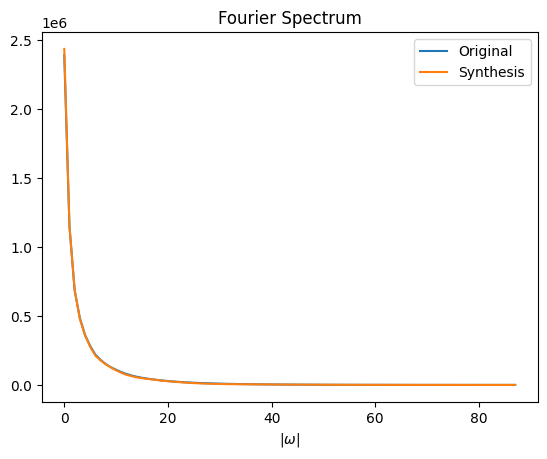

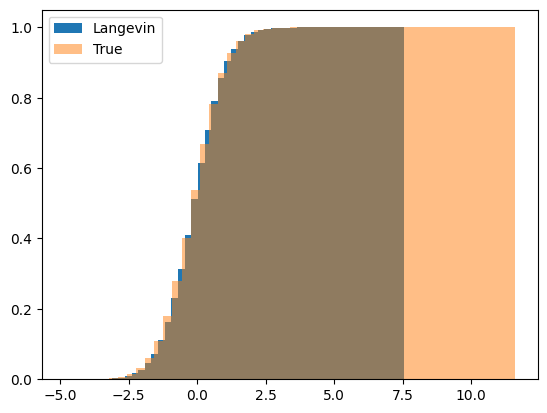

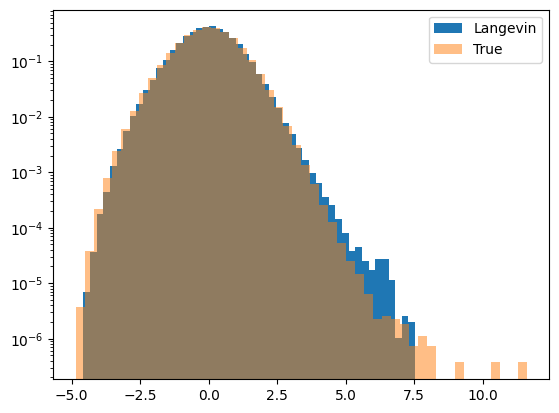

mean_true = tensor(-0.0126)
std_true = tensor(0.9958)
mean_langevin = tensor(-0.0061)
std_langevin = tensor(0.9795)


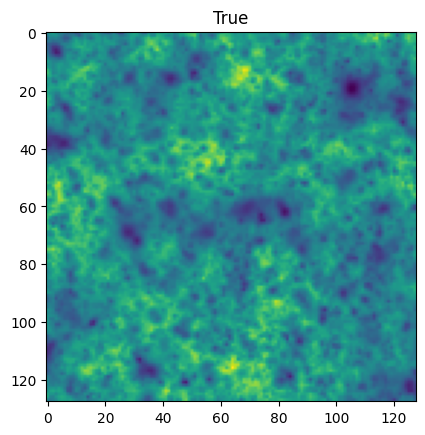

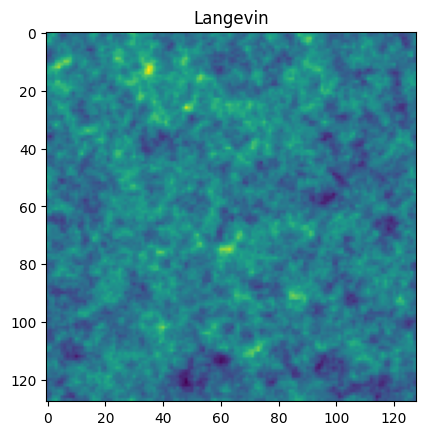

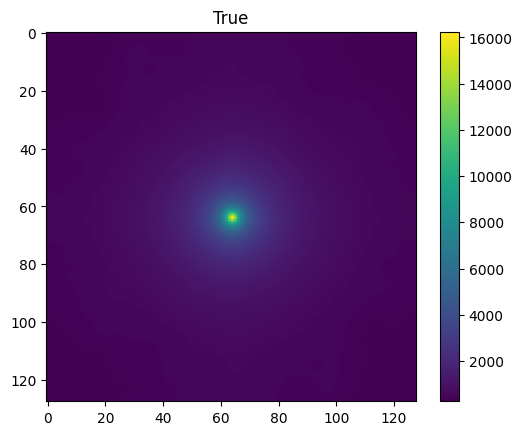

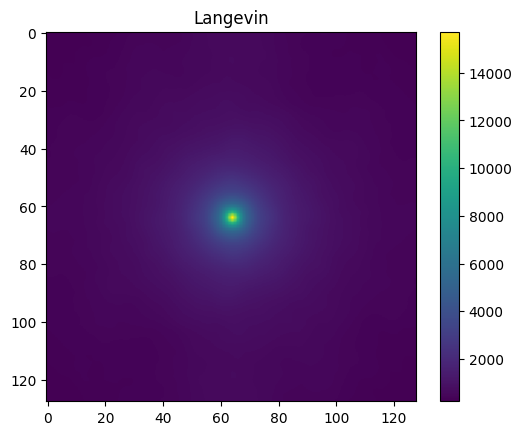

In [49]:
#Compare Synthesis and originals
Show_langevin(phi_s[::10],x_reco,log=True)

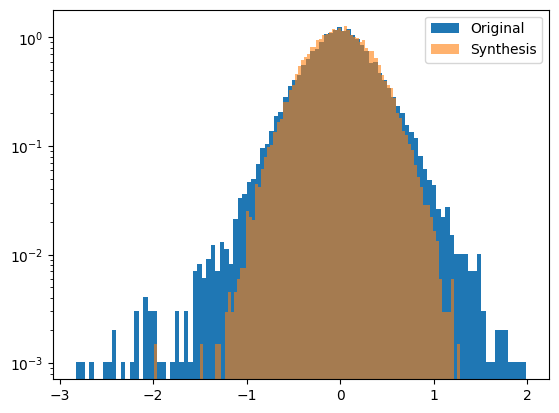

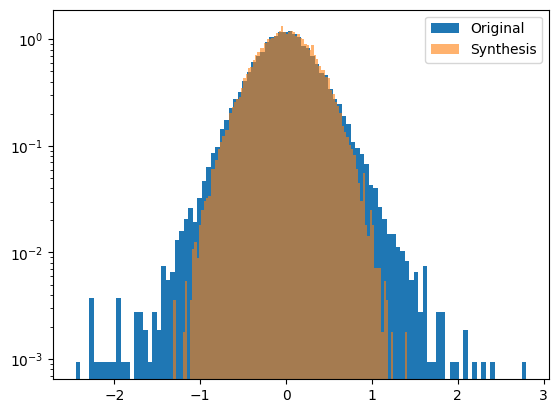

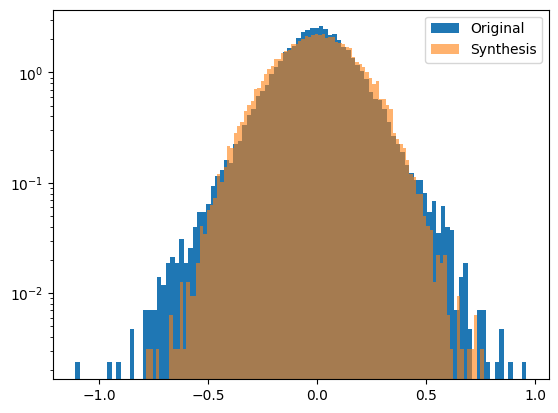

In [51]:
#Load The model we will sample from
ansatz = load_ansatz(L,KEY,dir_mod)
x_high_reco = ansatz.decompose(x_reco[::100].cuda())[1]
x_high = ansatz.decompose(phi_s[::100])[1][:len(x_reco[::100])]
compare_hist(x_high_reco[:,0],x_high[:,0],bins=100)
compare_hist(x_high_reco[:,1],x_high[:,1],bins=100)
compare_hist(x_high_reco[:,2],x_high[:,2],bins=100)

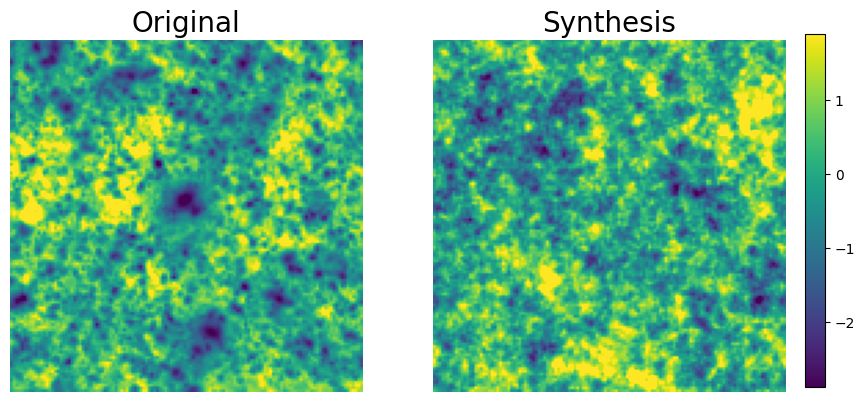

In [54]:
#Comparing samples of original and synthetised data
fig, (ax1,ax2) = plt.subplots(figsize=(10,7),nrows=1, ncols=2)
vmin = torch.quantile(phi_s[0], 0.005).cpu()
vmax = torch.quantile(phi_s[0], 0.995).cpu()


im = ax1.imshow(phi_s[2].cpu(),vmin=vmin,vmax=vmax) ; ax1.set_title('Original',fontsize=20)
ax1.axis('off')

ax2.imshow(x_reco[2].cpu(),vmin=vmin,vmax=vmax) ; ax2.set_title('Synthesis',fontsize=20)
ax2.axis('off')
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.505])
fig.colorbar(im, cax=cbar_ax)


plt.show()

In [55]:
!git clone 'https://github.com/jecampagne/scattering_transform.git'

fatal: destination path 'scattering_transform' already exists and is not an empty directory.


In [56]:
import torch
import torch.fft

In [57]:
import sys
sys.path.append('/pbs/home/c/campagne/my_sps/MacroCanoniqueStat/scattering_transform/')

In [58]:
# import scattering package
import scattering

use torch backend


In [59]:
M,N = 128,128
J = int(np.log2(min(M,N))) - 1
L = 4
st_calc = scattering.Scattering2d(M, N, J, L)

In [68]:
n_phi_s = phi_s.cpu().detach().numpy()

In [70]:
n_x_reco = x_reco.cpu().detach().numpy()

In [71]:
n_phi_s.shape, n_x_reco.shape

((5000, 128, 128), (500, 128, 128))

In [80]:
coeffs_phis = st_calc.scattering_coef(n_phi_s[:len(n_x_reco)])
coeffs_xreco = st_calc.scattering_coef(n_x_reco)

In [74]:
coeffs_phis.keys()

dict_keys(['var', 'mean', 'S0', 'S1', 'S1_iso', 'S2', 'S2_iso', 's21', 's22', 'P00', 'P00_iso', 'P11', 'P11_iso', 'for_synthesis', 'for_synthesis_iso'])

In [84]:
s1_phis =  np.log10(coeffs_phis['S1_iso'].cpu().numpy())
s1_xreco =  np.log10(coeffs_xreco['S1_iso'].cpu().numpy())


In [91]:
mean_s1_phis = np.mean(s1_phis,axis=0)
mean_s1_phis = np.std(s1_phis,axis=0)

mean_s1_xreco = np.mean(s1_xreco,axis=0)
mean_s1_xreco = np.std(s1_xreco,axis=0)


In [113]:
s21_phis = np.log10(coeffs_phis['s21'].cpu().detach().numpy())
s21_xreco = np.log10(coeffs_xreco['s21'].cpu().detach().numpy())


In [114]:
mean_s21_phis = np.mean(s21_phis,axis=0)
std_s21_phis = np.std(s21_phis,axis=0)


mean_s21_xreco = np.mean(s21_xreco,axis=0)
std_s21_xreco = np.std(s21_xreco,axis=0)


In [146]:
s22_phis = np.log10(coeffs_phis['s22'].cpu().detach().numpy())
s22_xreco = np.log10(coeffs_xreco['s22'].cpu().detach().numpy())


In [147]:
mean_s22_phis = np.mean(s22_phis,axis=0)
std_s22_phis = np.std(s22_phis,axis=0)


mean_s22_xreco = np.mean(s22_xreco,axis=0)
std_s22_xreco = np.std(s22_xreco,axis=0)


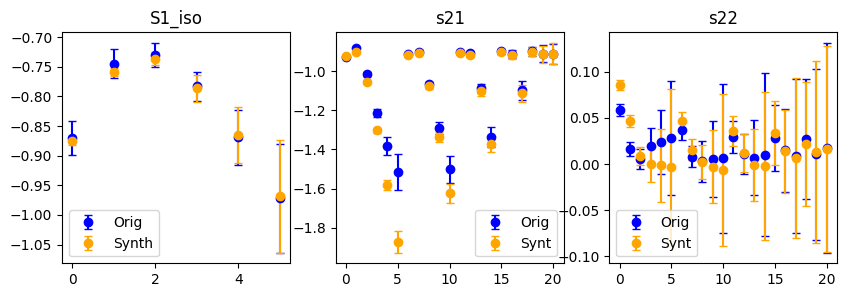

In [151]:
fig, ax= subplots(1,3,figsize=(10,3))

ax[0].errorbar(arange(J),mean_s1_phis,yerr=std_s1_phis,label="Orig",fmt='o',capsize=3,c="blue")
ax[0].errorbar(arange(J),mean_s1_xreco,yerr=std_s1_xreco,label="Synth",fmt='o',capsize=3,c='orange')
ax[0].set_title('S1_iso')
ax[0].legend();

ax[1].errorbar(np.arange(n_val),mean_s21_phis[np.triu_indices(J)],yerr=std_s21_phis[np.triu_indices(J)],label="Orig",fmt='o',capsize=3,mfc='blue',mec='blue',c='blue')
ax[1].errorbar(np.arange(n_val),mean_s21_xreco[np.triu_indices(J)],yerr=std_s21_xreco[np.triu_indices(J)],label="Synt",fmt='o',capsize=3,mfc='orange',mec='orange',c='orange')
ax[1].set_title('s21')
ax[1].legend();

ax[2].errorbar(np.arange(n_val),mean_s22_phis[np.triu_indices(J)],yerr=std_s22_phis[np.triu_indices(J)],label="Orig",fmt='o',capsize=3,mfc='blue',mec='blue',c='blue')
ax[2].errorbar(np.arange(n_val),mean_s22_xreco[np.triu_indices(J)],yerr=std_s22_xreco[np.triu_indices(J)],label="Synt",fmt='o',capsize=3,mfc='orange',mec='orange',c='orange')
ax[2].set_title('s22')
ax[2].legend();